# functiong說明

save_and_open_excel 存成EXCEL 然後 打開
>save_and_open_excel(dataframe, file_name="模型相關數值.xlsx")

analyze_nan_and_zero_values 檢視空值
>analyze_nan_and_zero_values(data, threshold, sort_column="零值+NAN佔比 (%)", ascending=False)

output_coefficients 輸出模型係數
>output_coefficients(model, poly_features, feature_names)

plot_confusion_matrix 繪製混淆矩陣的熱力圖
>plot_confusion_matrix(y_test, y_pred_lr)

In [1]:
def save_and_open_excel(dataframe, file_name="模型相關數值.xlsx"):
    """
    將給定的 dataframe 保存到指定的 Excel 工作表中，如果工作表已存在則覆蓋，
    並嘗試在支持的應用程式中打開該 Excel 文件。

    :param dataframe: 要保存的 pandas DataFrame。
    :param file_name: Excel 文件的名稱，默認為 'vif_data.xlsx'。
    """
    import pandas as pd
    import os

    # 獲取 dataframe 的變數名稱
    frame_name = [name for name, var in globals().items() if var is dataframe][0]

    # 檢查工作表是否存在，如果不存在則創建
    if not os.path.isfile(file_name):
        with pd.ExcelWriter(file_name, engine="openpyxl") as writer:
            dataframe.to_excel(writer, sheet_name=frame_name, index=False)
    else:
        # 工作表存在，加載工作簿
        with pd.ExcelWriter(
            file_name, engine="openpyxl", mode="a", if_sheet_exists="replace"
        ) as writer:
            dataframe.to_excel(writer, sheet_name=frame_name, index=False)

    # 嘗試打開創建的 Excel 文件
    try:
        os.startfile(file_name)
    except AttributeError:
        # 如果 os.startfile() 不可用（例如在非 Windows 系統上），使用適當的替代方案
        if os.name == "posix":
            os.system(f'open "{file_name}"')
        else:
            os.system(f'start "{file_name}"')
    except Exception as e:
        print(f"打開 Excel 文件時發生錯誤: {e}")

In [2]:
"""檢視空值及零值"""

import pandas as pd


def analyze_nan_and_zero_values(
    data, threshold, sort_column="零值+NAN佔比 (%)", ascending=False
):
    """
    檢查0值和 nan 的數量
    threshold 為 百分比，例threshold=20，會回傳 零值+NAN佔比 (%) 大於20% 的
    當 threshold = 0 會回傳全部
    """

    # 如果輸入是文件路徑，讀取CSV文件並轉換成Pandas DataFrame

    if isinstance(data, str):

        file_source_pd = pd.read_csv(data)

    # 如果輸入是Pandas DataFrame，直接使用它

    elif isinstance(data, pd.DataFrame):

        file_source_pd = data

    else:

        raise ValueError(
            "Invalid input type. Input must be either file path or Pandas DataFrame."
        )

    # 計算這個範圍內每一欄的空白值(NaN)數量

    nan_values_per_column_in_range = file_source_pd.isnull().sum(axis=0)

    # 計算每個欄位的總數據量

    total_data_per_column = len(file_source_pd)

    # 計算每個欄位的空白值(NaN)佔比

    nan_percentage_per_column = (
        nan_values_per_column_in_range / total_data_per_column
    ) * 100

    # 計算這個範圍內每一欄的零值數量

    zero_values_per_column_in_range = (file_source_pd == 0).sum(axis=0)

    # 計算每個欄位的零值佔比

    zero_percentage_per_column = (
        zero_values_per_column_in_range / total_data_per_column
    ) * 100

    # 計算每個欄位的零值和NaN值的總數

    total_zero_and_nan_per_column = (
        zero_values_per_column_in_range + nan_values_per_column_in_range
    )

    # 計算每個欄位的零值和NaN值總數的佔比

    total_zero_and_nan_percentage_per_column = (
        total_zero_and_nan_per_column / total_data_per_column
    ) * 100

    # 將結果轉換為 DataFrame

    values_df = pd.DataFrame(
        {
            "欄位名稱": nan_values_per_column_in_range.index,
            "零值+NAN佔比 (%)": total_zero_and_nan_percentage_per_column.values.round(
                2
            ),
            "空白值(NaN)數量": nan_values_per_column_in_range.values,
            "空白值(NaN)佔比 (%)": nan_percentage_per_column.values.round(2),
            "零值數量": zero_values_per_column_in_range.values,
            "零值佔比 (%)": zero_percentage_per_column.values.round(2),
        }
    )

    # 將 DataFrame 存儲到 CSV 檔案中
    values_df.to_csv("零值與空白值統計.csv", index=False, encoding="utf-8-sig")

    # 如果 threshold 等於 0，則返回所有欄位
    if threshold == 0:
        return values_df

    # 篩選出 '零值+NAN佔比 (%)' 大於指定閾值的欄位

    filtered_values_df = values_df[values_df["零值+NAN佔比 (%)"] > threshold]

    # 根據指定的列進行排序

    sorted_values_df = filtered_values_df.sort_values(
        by=sort_column, ascending=ascending
    )

    return sorted_values_df


# 測試


# result_df = analyze_nan_and_zero_values(clean_data, threshold=0, sort_column='欄位名稱', ascending=False)


# print(result_df)

In [55]:
"""輸出模型係數"""

import pandas as pd
import os


def output_coefficients(model, poly_features, feature_names):
    """
    model：你的模型物件，通常是訓練好的機器學習模型，例如線性回歸模型、支持向量機模型等。

    poly_features：多項式特徵物件，這通常是一個 PolynomialFeatures 物件，用於產生多項式特徵。

    feature_names：特徵名稱列表，這是一個包含特徵名稱的字串列表，用於識別每個特徵
    """
    coef = model.coef_
    intercept = model.intercept_

    # 創建包含係數和特徵名稱的DataFrame
    coef_data = {
        "係數": [coef[i] for i in range(len(coef)) if coef[i] != 0],
        "特徵": [feature_names[i] for i in range(len(coef)) if coef[i] != 0],
    }
    coef_df = pd.DataFrame(coef_data)
    coef_df = pd.concat(
        [pd.DataFrame({"係數": [intercept], "特徵": ["截距"]}), coef_df],
        ignore_index=True,
    )

    # 創建包含特徵名稱的DataFrame
    feature_names_df = pd.DataFrame({"特徵名稱": feature_names})

    # 輸出表格
    print("係數和截距表：")
    print(coef_df)
    print("\n特徵名稱表：")
    print(feature_names_df)

    # 將 DataFrame 存入 Excel
    coef_df.to_excel("coefficients.xlsx", index=False)

    # 使用 os 模組打開 Excel 檔案
    os.system("start coefficients.xlsx")

In [54]:
"""創建混合矩陣"""

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # 確保導入 numpy


def plot_confusion_matrix(y_true, y_pred, figsize=(10, 7), cmap="Blues"):
    """
    繪製混淆矩陣的熱力圖。

    參數:
    y_true -- 真實標籤
    y_pred -- 預測標籤
    figsize -- 圖形的大小 (預設為 (10, 7))
    cmap -- 熱力圖的顏色映射 (預設為 'Blues')
    """
    # 生成混淆矩陣
    cm = confusion_matrix(y_true, y_pred)

    # 轉換為比例
    cm_ratio = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # 使用 Seaborn 畫出混淆矩陣的熱力圖
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm_ratio, annot=True, fmt=".2f", cmap=cmap
    )  # fmt='.2f' 指定顯示兩位小數
    plt.title("Confusion Matrix")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.show()


# 使用此函數的示例
# plot_confusion_matrix(y_test, y_pred_lr)  # 調用函數繪製混淆矩陣

# 輸入資料

In [5]:
import pandas as pd

file_path = r"..\..\csv\飲料店總表0307final01_補上人氣_補值_hg.csv"

# dataset = pd.read_csv(file_path, sep=",", encoding="UTF-8")

dataset = pd.read_excel(file_path)
# print(dataset.info())


print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4742 entries, 0 to 4741
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           4742 non-null   object 
 1   star                           4742 non-null   float64
 2   comment                        4742 non-null   int64  
 3   class                          4742 non-null   object 
 4   address                        4742 non-null   object 
 5   latitude                       4742 non-null   float64
 6   longitude                      4742 non-null   float64
 7   school_counts                  4742 non-null   int64  
 8   drink_counts                   4742 non-null   int64  
 9   train_counts                   4742 non-null   int64  
 10  youbike_counts                 4742 non-null   int64  
 11  bus_counts                     4742 non-null   int64  
 12  park_counts                    4742 non-null   i

In [ ]:
dataset.describe().round(2)

In [ ]:
analyze_nan_and_zero_values(dataset, 0, sort_column="零值+NAN佔比 (%)", ascending=False)

## 選擇需要的資料

In [6]:
"""selected_data
"""

selected_data = dataset[
    [
        "star",
        "school_counts",
        "drink_counts",
        "train_counts",
        "youbike_counts",
        "bus_counts",
        "park_counts",
        "night_market_counts",
        "sports_facilities_counts",
        "mrt_counts",
        "movie_theater_counts",
        "hospital_counts",
        "salary_income_median",
        "people_flow_mean",
        "knock_down_price_mean",
        "weekend_open",
        "road_area_ratio",
        "age",
        "weekday_working_hours_average",
        # "comment",
        # "people_flow_average",
        "popularity",
    ]
]

# selected_data

## 刪掉關係性太低的


In [ ]:
# 计算相关系数矩阵
correlation_matrix = selected_data.corr()

# 提取特定列的相关系数
specific_column = "popularity"
correlation_with_specific_column = (
    correlation_matrix[specific_column].abs().sort_values()
)


# 印出相關係數
print(correlation_with_specific_column)

In [ ]:
selected_data_heat_map = dataset[
    [
        # "star",
        "school_counts",
        "drink_counts",
        # "train_counts",
        "youbike_counts",
        "bus_counts",
        "park_counts",
        # "night_market_counts",
        "sports_facilities_counts",
        "mrt_counts",
        "movie_theater_counts",
        "hospital_counts",
        "salary_income_median",
        # "people_flow_mean",
        # "knock_down_price_mean",
        "weekend_open",
        "road_area_ratio",
        "age",
        # "weekday_working_hours_average",
        # "comment",
        # "people_flow_average",
        "popularity",
    ]
]

In [ ]:
# 參數畫散點圖
import seaborn as sns

# sns.pairplot(sns.pairplot(selected_data_heat_map))
sns.pairplot(selected_data_heat_map)

In [ ]:
selected_data.describe()

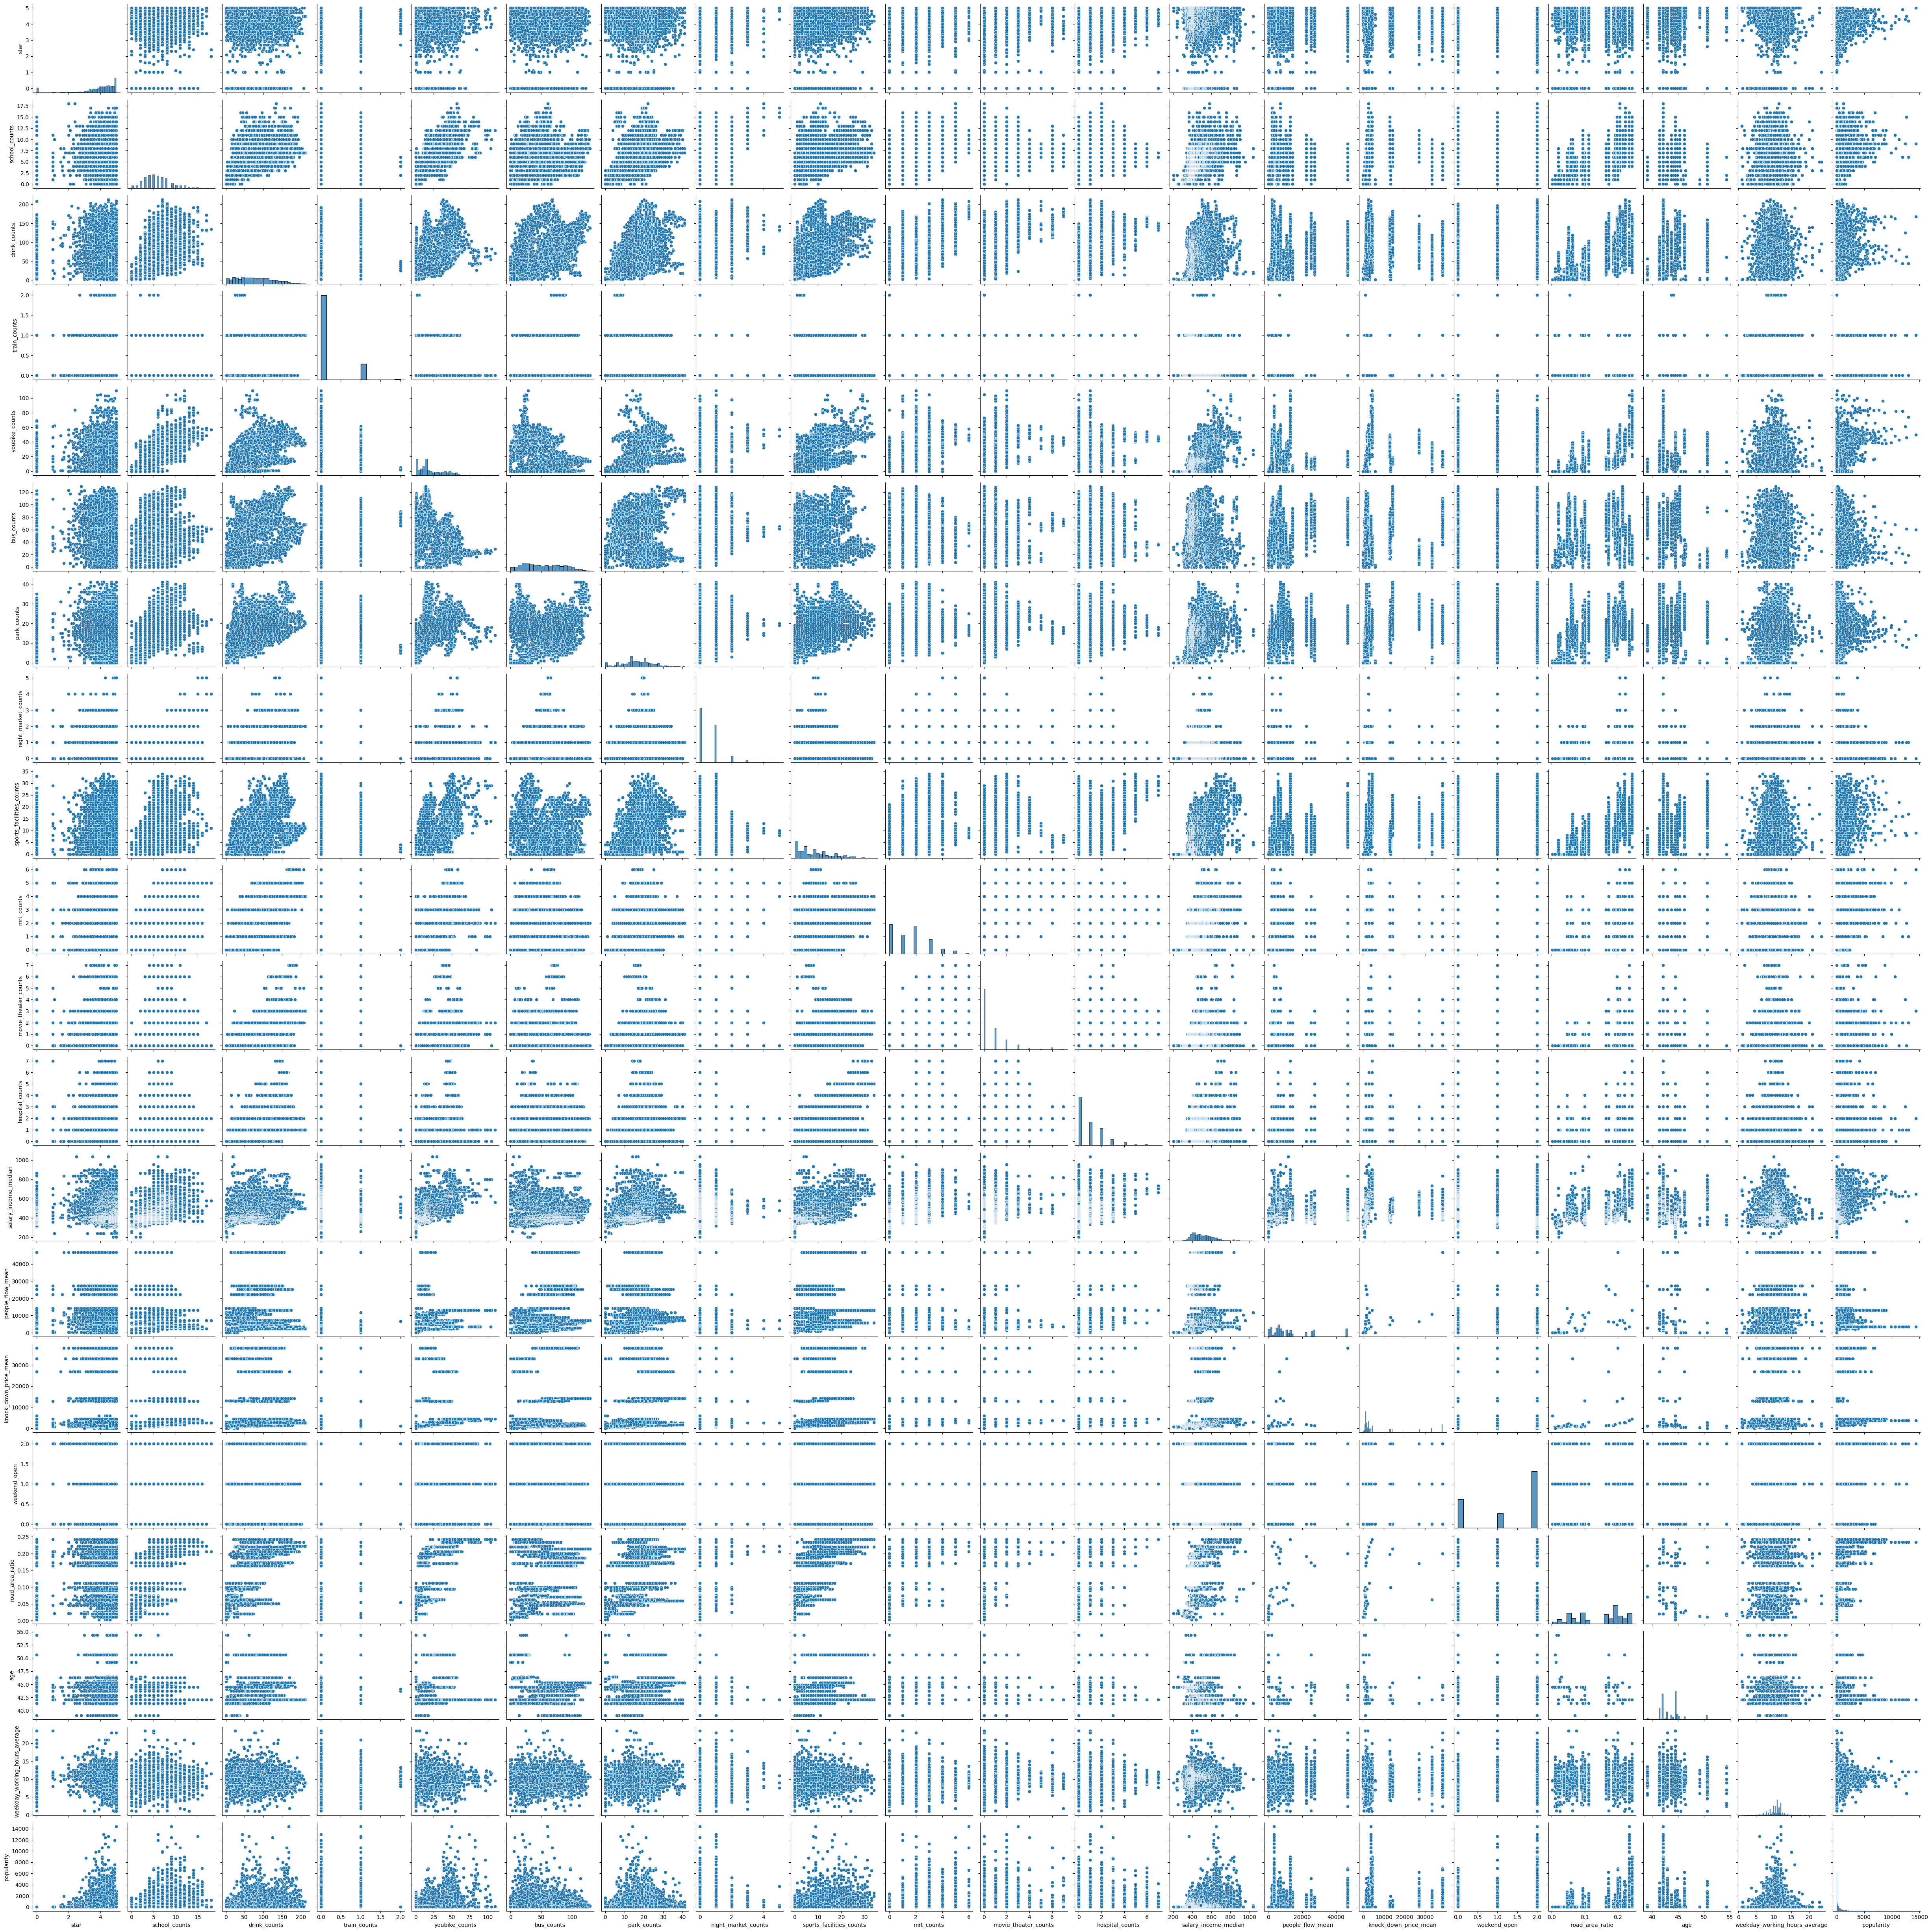

In [6]:
# 參數畫散點圖
import seaborn as sns

sns.pairplot(selected_data)

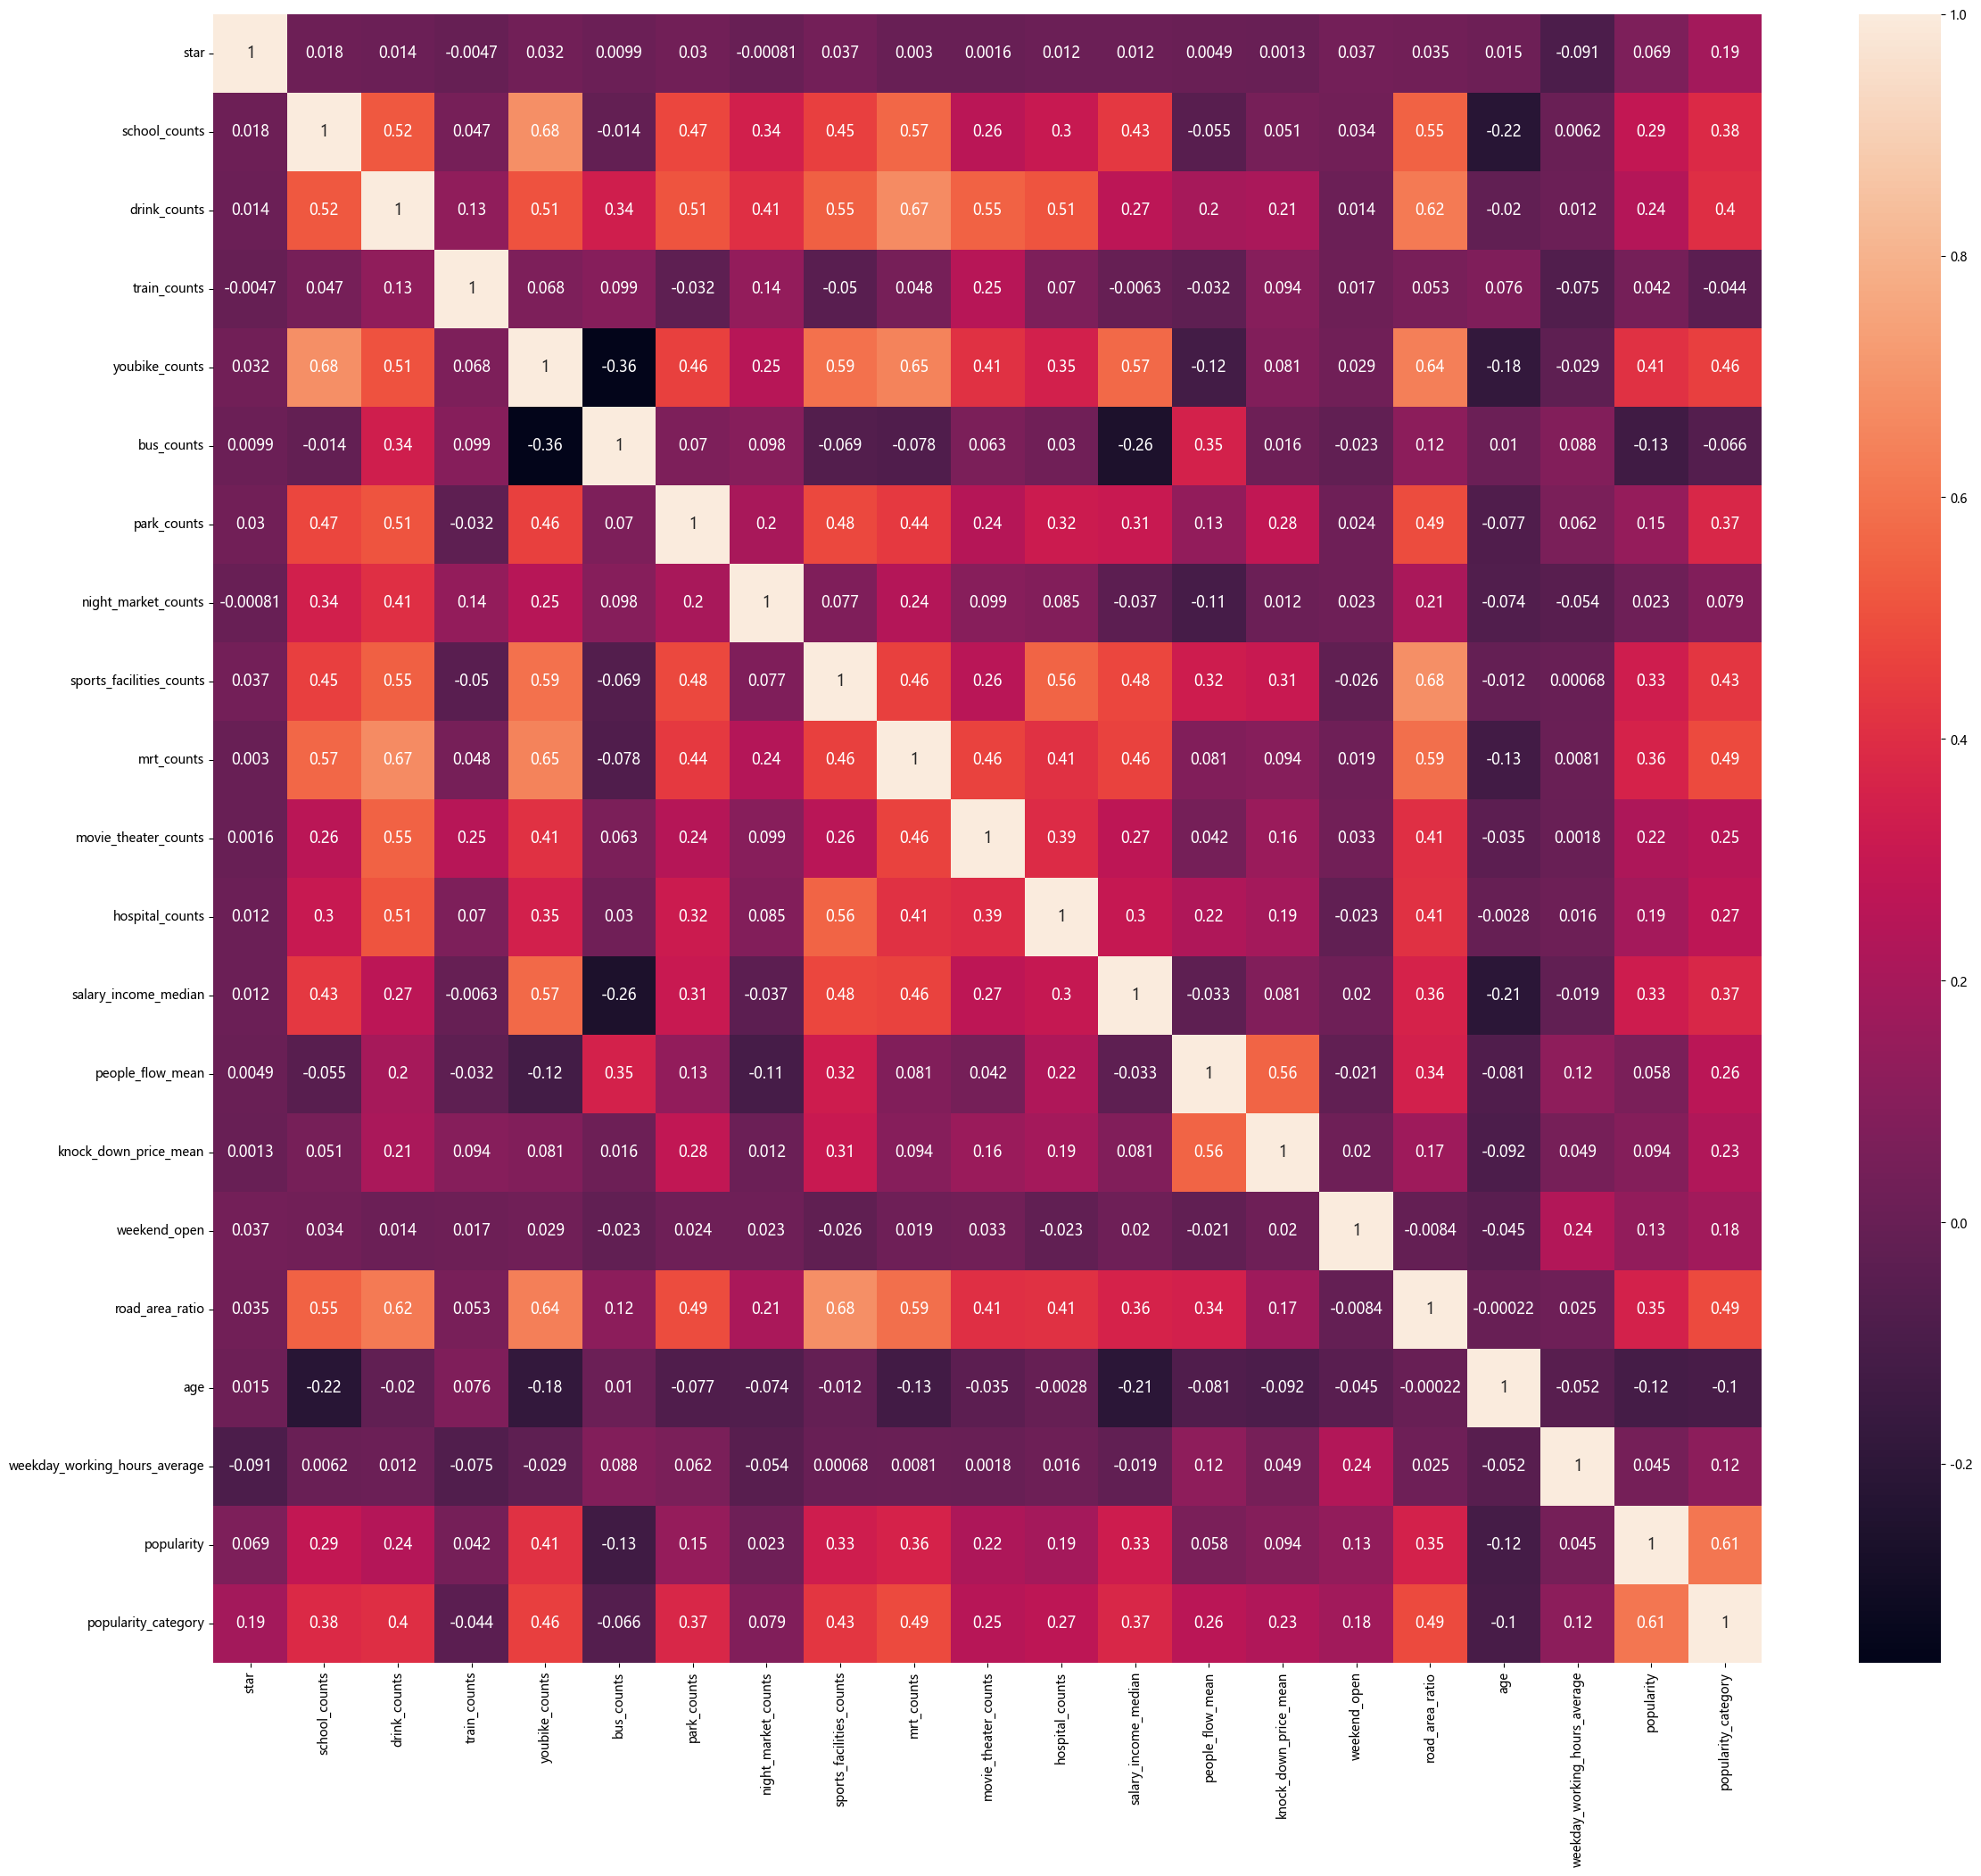

In [69]:
# 計算相關矩陣
import seaborn as sns
import matplotlib.pyplot as plt

corrmat = selected_data.corr()

# 繪製熱力圖
plt.figure(figsize=(28, 24))
sns.heatmap(corrmat, annot=True, annot_kws={"size": 12})
plt.show()

C:\Users\student\AppData\Local\Temp\ipykernel_3232\3021023438.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Y_classification_pd.groupby("category")["value"]


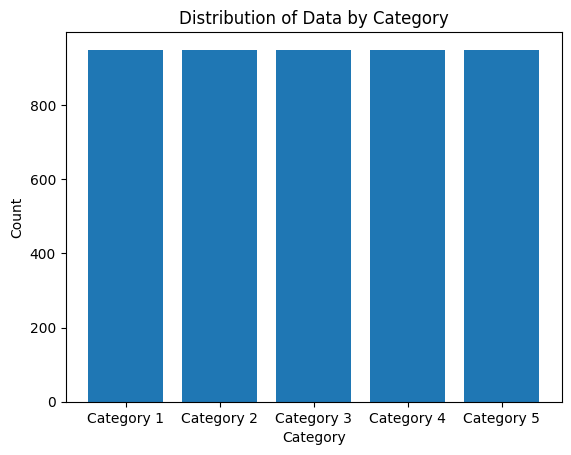

C:\Users\student\AppData\Local\Temp\ipykernel_3232\3021023438.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data["popularity_category"] = pd.cut(
C:\Users\student\AppData\Local\Temp\ipykernel_3232\3021023438.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data["popularity_category"] = selected_data["popularity_category"].fillna(5)


(popularity_category
 1    949
 2    948
 3    948
 4    948
 5    949
 Name: count, dtype: int64,
      category         最小值           最大值   數量
 0  Category 1    0.000000      3.254760  949
 1  Category 2    3.295444     85.328799  948
 2  Category 3   85.486327    313.433695  948
 3  Category 4  313.641095    861.541994  948
 4  Category 5  861.621606  14379.516993  949)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設的 selected_data 和 'popularity' 欄位數據
np.random.seed(0)

# 使用 pd.qcut 進行分類
Y_classification_pd = pd.DataFrame({"value": selected_data["popularity"]})
Y_classification_pd["category"] = pd.qcut(
    Y_classification_pd["value"],
    q=5,
    labels=["Category 1", "Category 2", "Category 3", "Category 4", "Category 5"],
)

# 分組並獲得統計信息
summary_df = (
    Y_classification_pd.groupby("category")["value"]
    .agg([("最小值", "min"), ("最大值", "max"), ("數量", "size")])
    .reset_index()
)

# 繪製數據分布
category_counts = Y_classification_pd["category"].value_counts().sort_index()
plt.bar(category_counts.index, category_counts.values)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Data by Category")
plt.show()

# 建立分類
value_category_ranges = [
    summary_df.loc[0, "最小值"],  # 第一類別的最小值
    summary_df.loc[1, "最小值"],  # 第二類別的最小值
    summary_df.loc[2, "最小值"],  # 第三類別的最小值
    summary_df.loc[3, "最小值"],  # 第四類別的最小值
    summary_df.loc[4, "最小值"],  # 第五類別的最小值
    summary_df.loc[4, "最大值"],  # 第五類別的最大值
]

# 使用 pd.cut 根據新的範圍劃分 'popularity' 欄位
selected_data["popularity_category"] = pd.cut(
    selected_data["popularity"],
    bins=value_category_ranges,
    right=False,  # 包括左邊界，排除右邊界
    labels=[1, 2, 3, 4, 5],
)

# 将超出范围的值设为最大范围
selected_data["popularity_category"] = selected_data["popularity_category"].fillna(5)

# selected_data['popularity_category'] = selected_data['popularity_category'].astype(int)

# 打印新的分類結果和每類的數量
selected_data["popularity_category"].value_counts().sort_index(), summary_df

In [ ]:
selected_data.info()

In [9]:
"""將連續數值popularity 轉成 類別數值 popularity_category
"""

# 設定模型輸入x
X = selected_data.drop(columns=["popularity", "popularity_category"])
y = selected_data[["popularity_category"]]

# 分割訓練和測試
from sklearn.model_selection import train_test_split

# test_size 切的尺寸 30% random_state讓抽取可以是穩定的結果(第一次抽根第十次抽是一樣的)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=25
)

In [ ]:
# selected_data.columns()
selected_data.columns
# X.columns
# y.columns

### 輸入前最後一次確認參數型態

In [11]:
# analyze_nan_and_zero_values(X, 0, sort_column="零值+NAN佔比 (%)", ascending=False)
analyze_nan_and_zero_values(y, 0, sort_column="零值+NAN佔比 (%)", ascending=False)

欄位名稱  零值+NAN佔比 (%)  空白值(NaN)數量  空白值(NaN)佔比 (%)  零值數量  \
0  popularity_category           0.0           0             0.0     0   

   零值佔比 (%)  
0       0.0

# 模型

## LogisticRegression

0.41531974701335206
              precision    recall  f1-score   support

           1       0.58      0.78      0.67       293
           2       0.28      0.26      0.27       281
           3       0.26      0.18      0.21       275
           4       0.30      0.18      0.22       276
           5       0.45      0.64      0.53       298

    accuracy                           0.42      1423
   macro avg       0.38      0.41      0.38      1423
weighted avg       0.38      0.42      0.39      1423



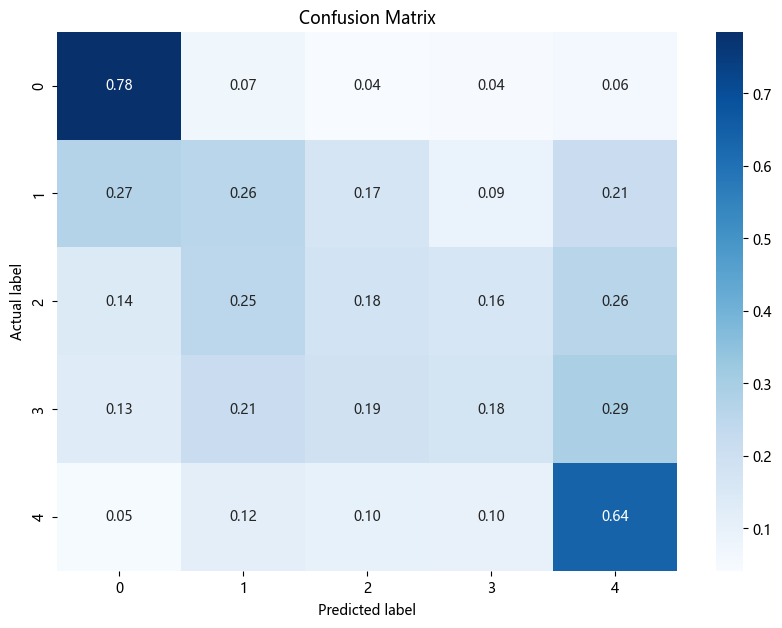

In [22]:
# 忽略警告用的
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


# 導入並訓練邏輯回歸(Logistic Regression)模型
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# 預測測試集並計算準確率
y_pred_lr = lr_model.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report

accuracy_lr = accuracy_score(y_test, y_pred_lr)
classification_report_lr = classification_report(y_test, y_pred_lr)

# 輸出結果
print(accuracy_lr)
print(classification_report_lr)

plot_confusion_matrix(y_test, y_pred_lr)

### 混淆矩陣(Confusion Matrix)

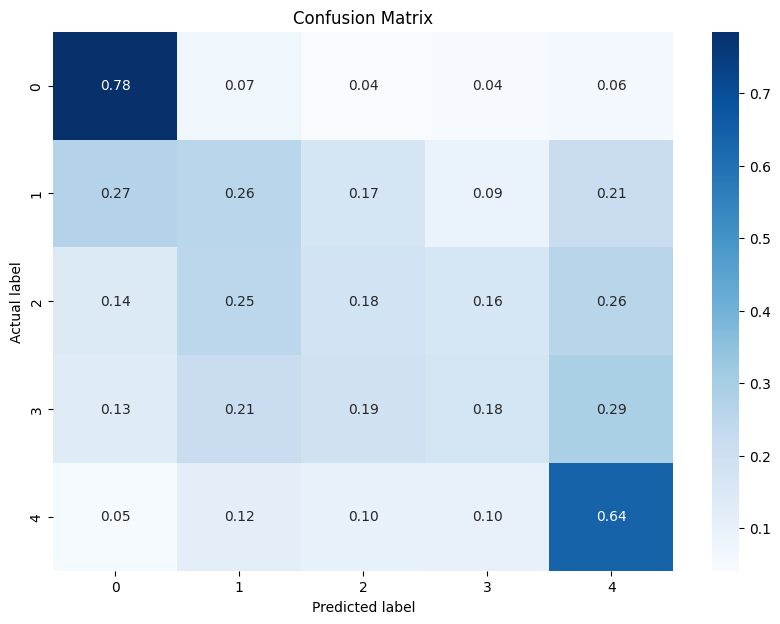

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 使用模型預測測試集
y_pred = lr_model.predict(X_test)

# 生成混淆矩陣
cm = confusion_matrix(y_test, y_pred_lr)


# 轉換為比例
cm_ratio = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# 使用Seaborn畫出混淆矩陣的熱力圖
plt.figure(figsize=(10, 7))
sns.heatmap(cm_ratio, annot=True, fmt=".2f", cmap="Blues")  # fmt='.2f' 指定顯示兩位小數
plt.title("Confusion Matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()

### 交叉驗證(Cross-Validation)

In [12]:
# 忽略警告用的
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


from sklearn.model_selection import cross_val_score

# 定義模型
lr_model_cv = LogisticRegression(max_iter=1000, random_state=42)

# 進行5-fold交叉驗證
scores = cross_val_score(lr_model_cv, X_train, y_train, cv=5)

# 輸出每一輪的準確率以及平均準確率
print("每一輪的準確率:", scores)
print("平均準確率:", scores.mean())

每一輪的準確率: [0.37198795 0.40361446 0.38855422 0.38704819 0.40573152]
平均準確率: 0.39138726853113814


c

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

C_values = np.logspace(-2, 6, 10)

# 定義原始參數範圍和模型（僅使用 L1 和 L2 正則化）
original_param_grid = {"C": C_values, "penalty": ["l1", "l2"]}
original_grid_search = GridSearchCV(
    LogisticRegression(
        max_iter=1000, random_state=42, solver="liblinear"
    ),  # 'liblinear' 支持 'l1' 和 'l2'
    original_param_grid,
    cv=5,
    scoring="accuracy",
)

# 執行原始網格搜索
original_grid_search.fit(X_train, y_train)
original_best_params = original_grid_search.best_params_
original_best_score = original_grid_search.best_score_

# 定義 Elastic Net 參數範圍和模型
elastic_param_grid = {
    "C": C_values,
    "l1_ratio": np.linspace(0, 1, 10),  # 從 0 到 1 均勻分布的 5 個點
}
elastic_grid_search = GridSearchCV(
    LogisticRegression(
        max_iter=1000, random_state=42, penalty="elasticnet", solver="saga"
    ),
    elastic_param_grid,
    cv=5,
    scoring="accuracy",
)

# 執行 Elastic Net 網格搜索
elastic_grid_search.fit(X_train, y_train)
elastic_best_params = elastic_grid_search.best_params_
elastic_best_score = elastic_grid_search.best_score_

# 比較結果並顯示
print("原始最佳參數:", original_best_params)
print("原始最高準確率:", original_best_score)
print("Elastic Net 最佳參數:", elastic_best_params)
print("Elastic Net 最高準確率:", elastic_best_score)

# 判斷哪一個模型更好
if original_best_score > elastic_best_score:
    print("原始模型較好。")
else:
    print("Elastic Net 模型較好。")

原始最佳參數: {'C': 278.2559402207126, 'penalty': 'l1'}
原始最高準確率: 0.4543549764669538
Elastic Net 最佳參數: {'C': 0.01, 'l1_ratio': 0.0}
Elastic Net 最高準確率: 0.3540274219048138
原始模型較好。


In [14]:
import matplotlib.pyplot as plt

# 解決字體問題
plt.rcParams["font.family"] = ["Microsoft YaHei"]
plt.rcParams["axes.unicode_minus"] = False

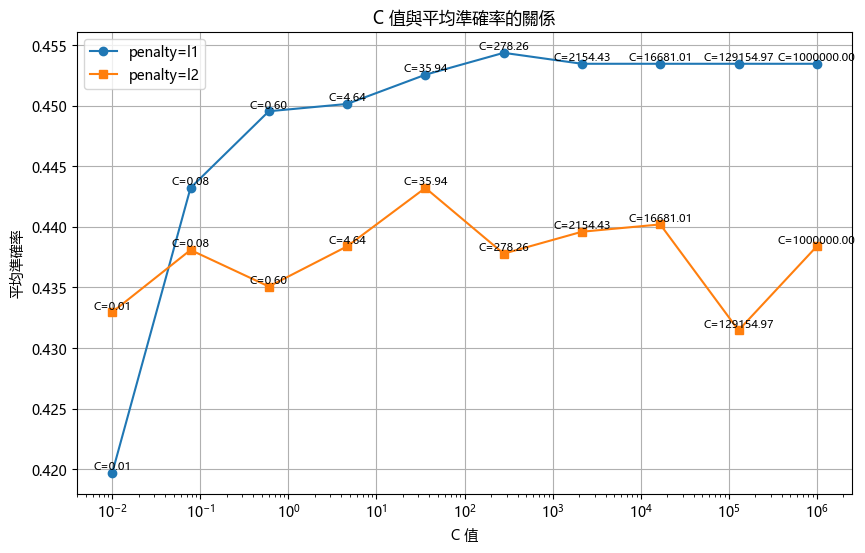

In [53]:
# 獲取參數組合和對應的準確率
params = original_grid_search.cv_results_["params"]
mean_scores = original_grid_search.cv_results_["mean_test_score"]

# 繪製原始模型的準確率與 C 值的關係圖表
plt.figure(figsize=(10, 6))
for penalty, marker in zip(["l1", "l2"], ["o", "s"]):
    penalty_mask = [param["penalty"] == penalty for param in params]
    plt.plot(
        C_values, mean_scores[penalty_mask], marker=marker, label=f"penalty={penalty}"
    )

    # 標記每個參數組合
    for i, c in enumerate(C_values):
        plt.text(
            c,
            mean_scores[penalty_mask][i],
            f"C={c:.2f}",
            fontsize=8,
            ha="center",
            va="bottom",
        )

plt.xscale("log")
plt.xlabel("C 值")
plt.ylabel("平均準確率")
plt.title("C 值與平均準確率的關係")
plt.legend()
plt.grid(True)
plt.show()

### 使用最好的C

準確率: 0.4701335207308503
分類報告:
               precision    recall  f1-score   support

           1       0.68      0.86      0.76       293
           2       0.29      0.21      0.25       281
           3       0.31      0.27      0.29       275
           4       0.36      0.28      0.31       276
           5       0.52      0.69      0.60       298

    accuracy                           0.47      1423
   macro avg       0.43      0.46      0.44      1423
weighted avg       0.44      0.47      0.45      1423



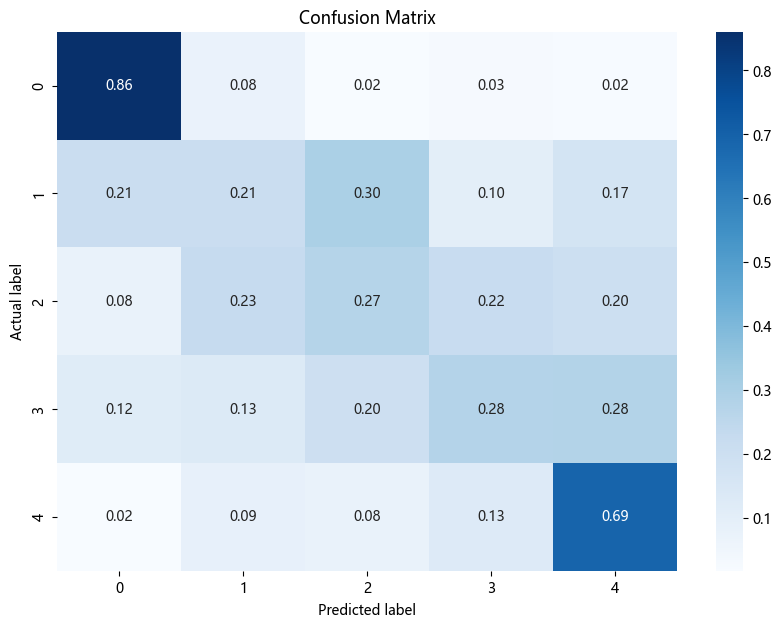

每一輪的準確率: [0.4186747  0.49096386 0.44427711 0.45933735 0.45852187]
平均準確率: 0.4543549764669538


['lr_model_best.joblib']

In [16]:
"""使用最好的C"""

# 導入並訓練邏輯回歸(Logistic Regression)模型
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# 使用原始模型的最佳參數來設定模型
lr_model_best = LogisticRegression(
    C=278.2559402207126,
    penalty="l1",
    solver="liblinear",
    max_iter=1000,
    random_state=42,
)
lr_model_best.fit(X_train, y_train)

# 預測測試集並計算準確率
y_pred_best_lr = lr_model_best.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report

accuracy_lr = accuracy_score(y_test, y_pred_best_lr)
classification_report_lr = classification_report(y_test, y_pred_best_lr)

# 輸出結果
print("準確率:", accuracy_lr)
print("分類報告:\n", classification_report_lr)

"""建立混淆矩陣"""

plot_confusion_matrix(y_test, y_pred_best_lr)


"""交叉驗證(Cross-Validation)"""
# 進行5-fold交叉驗證
scores = cross_val_score(lr_model_best, X_train, y_train, cv=5)

# 輸出每一輪的準確率以及平均準確率
print("每一輪的準確率:", scores)
print("平均準確率:", scores.mean())

"""輸出模型"""
from joblib import dump, load

# 保存模型
dump(lr_model_best, "lr_model_best.joblib")

### 模型係數(Coefficients)

                          Feature  Coefficient
3                    train_counts     0.743272
10           movie_theater_counts     0.478435
11                hospital_counts     0.234261
7             night_market_counts     0.119488
8        sports_facilities_counts     0.110515
17                            age     0.091454
5                      bus_counts     0.012343
14          knock_down_price_mean    -0.000033
13               people_flow_mean    -0.000165
12           salary_income_median    -0.004689
2                    drink_counts    -0.017495
4                  youbike_counts    -0.032587
6                     park_counts    -0.052289
1                   school_counts    -0.082390
18  weekday_working_hours_average    -0.110884
15                   weekend_open    -0.470156
9                      mrt_counts    -0.680448
0                            star    -1.434280
16                road_area_ratio    -8.091701


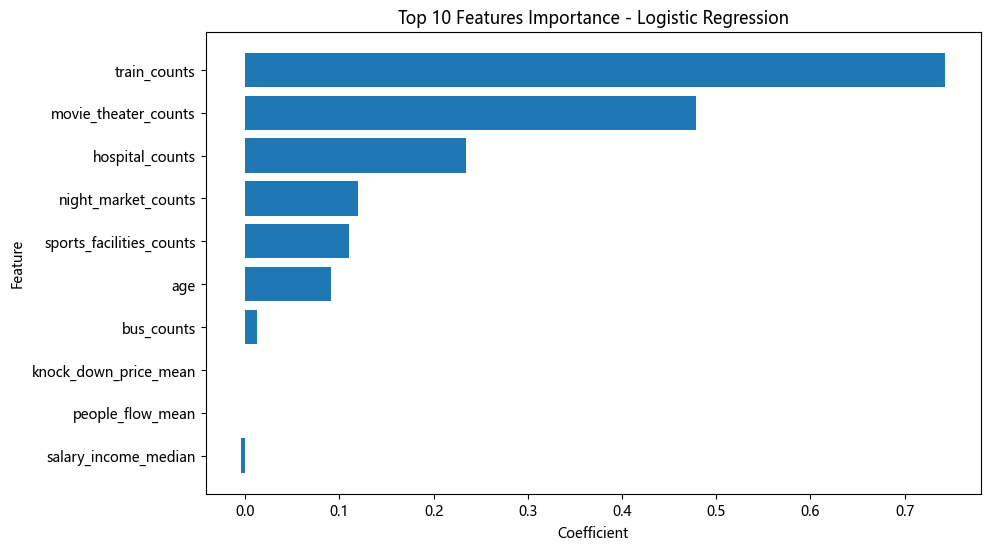

In [59]:
# 查看模型係數
import pandas as pd

feature_names = X_train.columns
coefficients = lr_model_best.coef_[0]
feature_importance = pd.DataFrame(
    {"Feature": feature_names, "Coefficient": coefficients}
)
feature_importance = feature_importance.sort_values(by="Coefficient", ascending=False)
print(feature_importance)

# 確保DataFrame已經根據Coefficient進行降序排序
feature_importance_sorted = feature_importance.sort_values(
    by="Coefficient", ascending=False
)

# 繪製特徵重要性的水平條形圖，重要性較高的特徵會顯示在最上面
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_sorted["Feature"][:10],
    feature_importance_sorted["Coefficient"][:10],
)
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Top 10 Features Importance - Logistic Regression")
plt.gca().invert_yaxis()  # 確保重要性較高的特徵顯示在最上面
plt.show()

## SVM

0.35628952916373857
              precision    recall  f1-score   support

           1       0.60      0.72      0.66       293
           2       0.22      0.36      0.27       281
           3       0.28      0.42      0.34       275
           4       0.28      0.11      0.15       276
           5       0.45      0.17      0.25       298

    accuracy                           0.36      1423
   macro avg       0.37      0.35      0.33      1423
weighted avg       0.37      0.36      0.34      1423



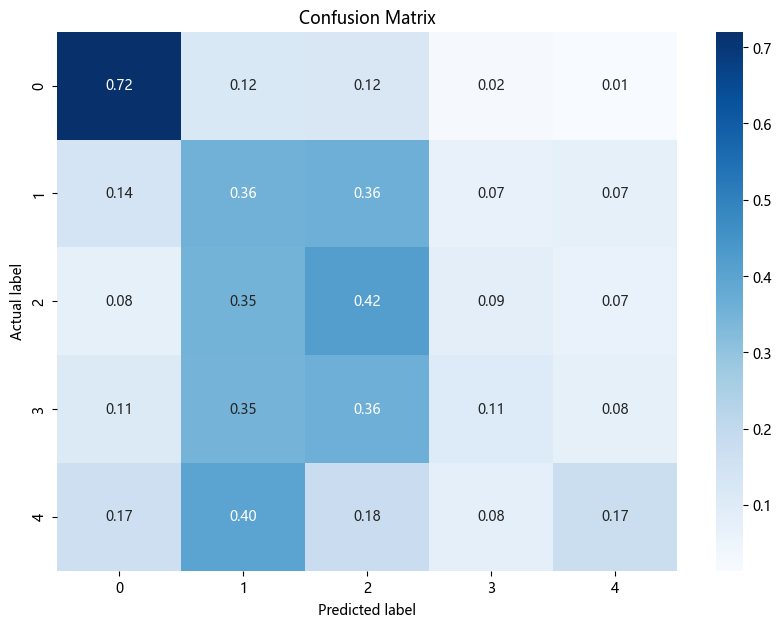

In [17]:
from sklearn.svm import SVC

# 訓練支持向量機模型，默認 高斯核（RBF核）
# svm_model = SVC(kernel='rbf', random_state=42)
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# 預測測試集
y_pred_svm = svm_model.predict(X_test)

# 計算準確率和顯示分類報告
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_report_svm = classification_report(y_test, y_pred_svm)

print(accuracy_svm)
print(classification_report_svm)

plot_confusion_matrix(y_test, y_pred_svm)

### 交叉驗證(Cross-Validation)

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# 初始化支持向量機模型
svm_model = SVC(random_state=42)

# 進行交叉驗證，這裡假設使用5折交叉驗證
scores = cross_val_score(svm_model, X_train, y_train, cv=5)

# 打印出每一折的準確率以及平均準確率
print("每一折的準確率: ", scores)
print("交叉驗證結果：平均準確率", scores.mean())

每一折的準確率:  [0.33433735 0.35391566 0.38554217 0.35542169 0.3438914 ]
交叉驗證結果：平均準確率 0.35462165403696233


### 參數調整(Parameter Tuning)

In [76]:
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import expon, reciprocal
import numpy as np
import matplotlib.pyplot as plt

# 忽略警告
warnings.filterwarnings("ignore", category=UserWarning)

grid_C_values = [0.1, 1, 10, 100]
dist_C_values = reciprocal(0.1, 100)

# 設定參數範圍和分佈
param_grid = {"C": grid_C_values, "gamma": [1, 0.1, 0.01, 0.001]}
param_dist = {"C": dist_C_values, "gamma": expon(scale=1.0)}

# 創建 GridSearchCV 和 RandomizedSearchCV 物件
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=0)
random_search = RandomizedSearchCV(
    SVC(), param_distributions=param_dist, n_iter=100, refit=True, verbose=0
)

# 執行擬合
grid_search.fit(X_train, y_train)
random_search.fit(X_train, y_train)

# 整理出圖的數據
results_grid = grid_search.cv_results_
results_random = random_search.cv_results_

最佳參數 (Grid Search CV):  {'C': 1, 'gamma': 0.001}
最佳參數(Randomized Search CV):  {'C': 51.75391791015341, 'gamma': 0.03828291220734791}


In [87]:
# 顯示最佳參數和最佳準確率
best_grid_params = grid_search.best_params_
best_random_params = random_search.best_params_
best_grid_score = grid_search.best_score_
best_random_score = random_search.best_score_


# 比較準確率並指出哪個更高，然後創建相應的 SVC 實例
if best_grid_score > best_random_score:
    print("最佳參數 (Grid Search CV): ", best_grid_params)
    print("最佳準確率 (Grid Search CV): ", best_grid_score)
    # 直接使用具體的參數值來創建 SVC 實例
    svc_best = SVC(C=best_grid_params["C"], gamma=best_grid_params["gamma"])
elif best_grid_score < best_random_score:
    print("最佳參數 (Randomized Search CV): ", best_random_params)
    print("最佳準確率 (Randomized Search CV): ", best_random_score)
    # 直接使用具體的參數值來創建 SVC 實例
    svc_best = SVC(C=best_random_params["C"], gamma=best_random_params["gamma"])
else:
    print("兩種搜索方法提供了相同的準確率。")
    # 可以選擇任何一組參數來創建 SVC 實例，這裡選擇了 Grid Search 的參數
    svc_best = SVC(C=best_grid_params["C"], gamma=best_grid_params["gamma"])

"""交叉驗證"""

from sklearn.model_selection import cross_val_score

# cross_val_scores_best

svc_best = SVC(C=best_grid_params["1"], gamma=best_grid_params["0.001"])

# 進行交叉驗證
cross_val_scores_best = cross_val_score(svc_best, X_train, y_train, cv=5)

# 計算平均交叉驗證準確率
avg_score_best = np.mean(cross_val_scores_best)

# 顯示結果
print("平均交叉驗證準確率 (Grid Search CV): ", avg_score_best)

最佳參數 (Grid Search CV):  {'C': 1, 'gamma': 0.001}
最佳準確率 (Grid Search CV):  0.4154895600501553


In [21]:
"""交叉驗證"""

from sklearn.model_selection import cross_val_score

# cross_val_scores_best

svc_best = SVC(C=1, gamma=0.001)

# 進行交叉驗證
cross_val_scores_best = cross_val_score(svc_best, X_train, y_train, cv=5)

# 計算平均交叉驗證準確率
avg_score_best = np.mean(cross_val_scores_best)

# 顯示結果
print("平均交叉驗證準確率 (Grid Search CV): ", avg_score_best)

"""輸出模型"""
from joblib import dump

# 保存模型
dump(svc_best, "svc_best.joblib")

平均交叉驗證準確率 (Grid Search CV):  0.4154895600501553


['svc_best.joblib']

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

# 假定您已經有了 X_test 和 y_test
y_pred = svc_best.predict(X_test)

# 獲得混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred)
print("混淆矩陣:")
print(conf_matrix)

# 使用 Matplotlib 繪製混淆矩陣
plot_confusion_matrix(svc_best, X_test, y_test)
plt.show()

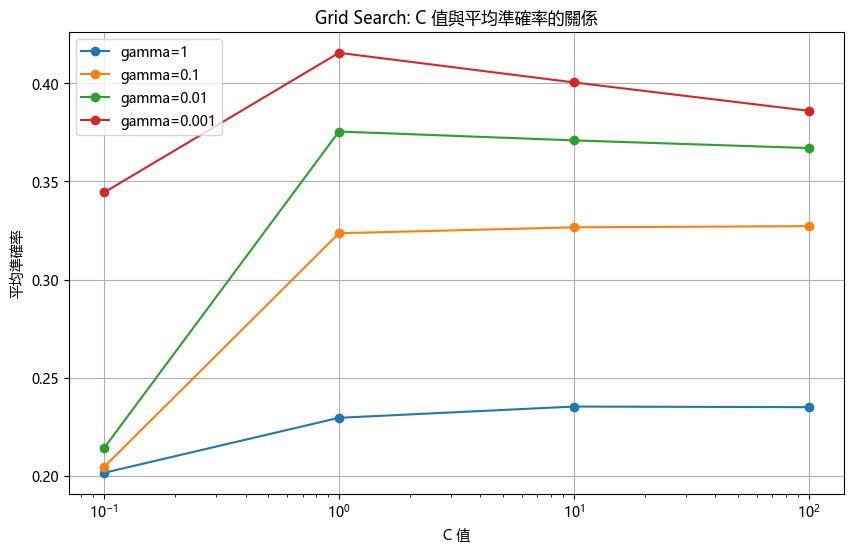

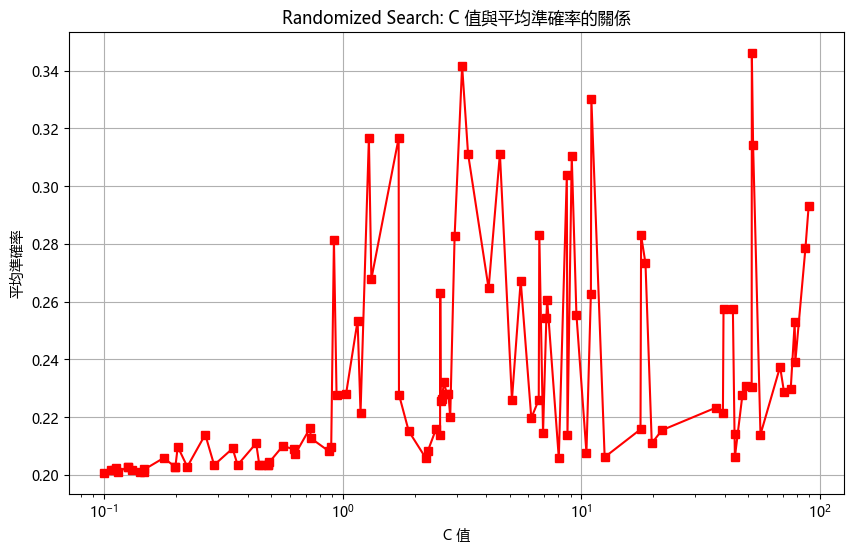

In [82]:
import matplotlib.pyplot as plt

grid_C_values = [0.1, 1, 10, 100]
dist_C_values = reciprocal(0.1, 100)

# Grid Search CV 的準確率與 C 值的關係圖
plt.figure(figsize=(10, 6))
for gamma_value in param_grid["gamma"]:
    gamma_mask = [param["gamma"] == gamma_value for param in results_grid["params"]]
    scores = [
        results_grid["mean_test_score"][i]
        for i in range(len(gamma_mask))
        if gamma_mask[i]
    ]
    plt.plot(grid_C_values, scores, marker="o", label=f"gamma={gamma_value}")

plt.xscale("log")
plt.xlabel("C 值")
plt.ylabel("平均準確率")
plt.title("Grid Search: C 值與平均準確率的關係")
plt.legend()
plt.grid(True)
plt.show()

# Randomized Search CV 的準確率與 C 值的關係圖
plt.figure(figsize=(10, 6))
# 從 Randomized Search CV 的結果中提取 C 值和對應的平均準確率
C_values_random = [param["C"] for param in results_random["params"]]
mean_scores_random = results_random["mean_test_score"]

# 排序以保持 C 值的升序
sorted_indices = np.argsort(C_values_random)
C_values_sorted = np.array(C_values_random)[sorted_indices]
mean_scores_sorted = np.array(mean_scores_random)[sorted_indices]

plt.plot(C_values_sorted, mean_scores_sorted, marker="s", linestyle="-", color="r")
plt.xscale("log")
plt.xlabel("C 值")
plt.ylabel("平均準確率")
plt.title("Randomized Search: C 值與平均準確率的關係")
plt.grid(True)
plt.show()

### SVM REF

In [91]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [92]:
# 初始化SVC模型
svc_best = SVC(kernel="linear")  # 假設使用線性核，可根據實際情況修改

# 訓練SVC模型
svc_best_REF = svc_best
svc_best_REF.fit(X_train, y_train)

# 初始化RFE，設定想要保留的特徵數量，此處為保留1個特徵，每次移除1個特徵
selector = RFE(svc_best_REF, n_features_to_select=1, step=1)

# 在訓練集上應用RFE
selector = selector.fit(X_train, y_train)

# 打印出被選中的特徵和它們的排名
print("被選擇的特徵：", selector.support_)
print("特徵排名：", selector.ranking_)

# 使用RFE選擇的特徵轉換測試集
X_test_transformed = selector.transform(X_test)

# 使用訓練好的模型預測測試集
y_pred = svc_best_REF.predict(X_test_transformed)

# 評估模型在測試集上的性能
print("準確度：", accuracy_score(y_test, y_pred))
print("分類報告：", classification_report(y_test, y_pred))

In [ ]:
feature_ranking = selector.ranking_

# 创建一个DataFrame来储存特徵和它们的排名
# 这假设X_train有一个columns属性，这通常是Pandas DataFrame的情况
ranking_df = pd.DataFrame({"Feature": X_train.columns, "Ranking": feature_ranking})

# 根据排名对特徵进行排序
ranking_df = ranking_df.sort_values("Ranking")

# 重置索引，以便顺序反映了移除特徵的顺序
ranking_df = ranking_df.reset_index(drop=True)

# 显示特徵及其排名
print(ranking_df)

### XGboost

In [23]:
pip install xgboost -q


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# 因為 XGBoost 裡面的 softmax 、 softprob預測值 都要從0開始
y_train_transformed = y_train.iloc[:, 0].astype("int") - 1
y_test_transformed = y_test.iloc[:, 0].astype("int") - 1
# y_test_transformed

Accuracy: 0.5108924806746311
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       293
           1       0.39      0.36      0.38       281
           2       0.35      0.36      0.35       275
           3       0.35      0.35      0.35       276
           4       0.54      0.58      0.56       298

    accuracy                           0.51      1423
   macro avg       0.50      0.51      0.50      1423
weighted avg       0.51      0.51      0.51      1423



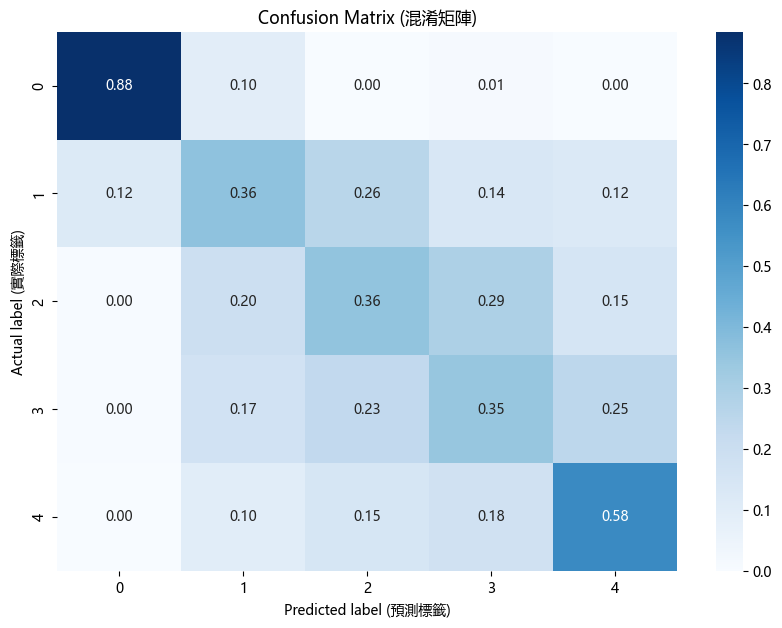

In [44]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 訓練 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=5, random_state=42)
xgb_model.fit(X_train, y_train_transformed)

# 進行預測
y_pred_xgb_transformed = xgb_model.predict(X_test)

# 計算準確率和其他性能指標
accuracy_xgb = accuracy_score(y_test_transformed, y_pred_xgb_transformed)
classification_report_xgb = classification_report(
    y_test_transformed, y_pred_xgb_transformed
)

# 將預測結果轉換回原始範圍（1~5）
y_pred_xgb_original = y_pred_xgb_transformed + 1

# 輸出結果
print(f"Accuracy: {accuracy_xgb}")
print("Classification Report:\n", classification_report_xgb)

# 如果您需要使用預測結果進行其他操作，請使用 y_pred_xgb_original

# 計算混淆矩陣
cm = confusion_matrix(y_test_transformed, y_pred_xgb_transformed)

# 轉換為比例
cm_ratio = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# 使用Seaborn畫出混淆矩陣的熱力圖
plt.figure(figsize=(10, 7))
sns.heatmap(cm_ratio, annot=True, fmt=".2f", cmap="Blues")  # fmt='.2f' 指定顯示兩位小數
plt.title("Confusion Matrix (混淆矩陣)")
plt.ylabel("Actual label (實際標籤)")
plt.xlabel("Predicted label (預測標籤)")
plt.show()

### 交叉驗證(Cross-Validation)

In [45]:
y_transformed = y.iloc[:, 0].astype("int") - 1

In [47]:
from sklearn.model_selection import cross_val_score

# 定義 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=5, random_state=42)

# 執行交叉驗證
# cv 參數決定折數，例如，cv=5 代表 5 折交叉驗證
# scoring 參數可以根據需要更改，例如使用 'accuracy' 來獲取準確率
scores = cross_val_score(xgb_model, X, y_transformed, cv=5, scoring="accuracy")

# 輸出結果
print("每一輪的準確率:", scores)
print("平均準確率:", scores.mean())
# print('Standard deviation of accuracy:', scores.std())

每一輪的準確率: [0.39515279 0.3719705  0.28375527 0.22890295 0.38607595]
平均準確率: 0.33317149297728454


### 參數調整(Parameter Tuning)

In [62]:
from sklearn.model_selection import GridSearchCV


# 定義超參數網格
param_grid = {
    "max_depth": [3, 4, 5],  # 最大深度
    "learning_rate": [0.1, 0.01, 0.001],  # 學習率
    "n_estimators": [100, 200, 300],  # 樹的數量
    "objective": ["multi:softmax", "multi:softprob"],  # 目標函數
    "subsample": [0.6, 0.8, 1],  # 子樣本比例
    "colsample_bytree": [0.8, 1, 1.2],  # 每棵樹隨機選擇特徵的比例
}

# 初始化XGBoost分類器
xgb_classifier = xgb.XGBClassifier(random_state=42, num_class=5)

# 設置GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
    cv=3,
    verbose=2,
)

# 擬合GridSearchCV
grid_search.fit(X_train, y_train_transformed)

# 輸出最佳參數
print("找到的最佳參數: ", grid_search.best_params_)

# 輸出最佳準確率
print("找到的最佳準確率: ", grid_search.best_score_)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
486 fits failed out of a total of 1458.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
486 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\student\AppData\Local\Programs\Python\Python312\Lib

找到的最佳參數:  {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'objective': 'multi:softmax', 'subsample': 0.8}
找到的最佳準確率:  0.5230518379123916


### 用最好的參數做

最佳模型準確率: 0.5298664792691496
最佳模型分類報告:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90       293
           1       0.52      0.19      0.28       281
           2       0.32      0.48      0.38       275
           3       0.41      0.30      0.35       276
           4       0.54      0.71      0.62       298

    accuracy                           0.53      1423
   macro avg       0.53      0.52      0.51      1423
weighted avg       0.54      0.53      0.51      1423



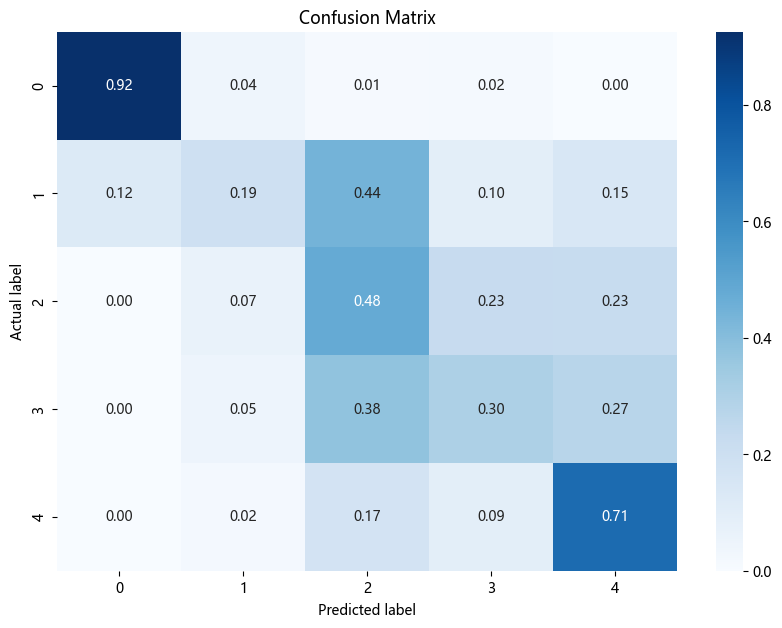

['XGBoost model_best.joblib']

In [63]:
# 使用最佳參數對整個訓練集進行重新訓練
best_xgb_model = grid_search.best_estimator_

# 進行預測
y_pred_best_XG = best_xgb_model.predict(X_test)

# 計算準確率和其他性能指標
accuracy_best = accuracy_score(y_test_transformed, y_pred_best_XG)
classification_report_best = classification_report(y_test_transformed, y_pred_best_XG)

# 輸出結果
print(f"最佳模型準確率: {accuracy_best}")
print("最佳模型分類報告:\n", classification_report_best)

plot_confusion_matrix(y_test_transformed, y_pred_best_XG)

"""輸出模型"""
from joblib import dump, load

# 保存模型
dump(best_xgb_model, "XGBoost model_best.joblib")

                          Feature  Importance
14          knock_down_price_mean    0.305537
16                road_area_ratio    0.192518
0                            star    0.094009
13               people_flow_mean    0.064875
4                  youbike_counts    0.044751
9                      mrt_counts    0.043032
17                            age    0.039330
15                   weekend_open    0.030636
12           salary_income_median    0.027679
10           movie_theater_counts    0.021787
5                      bus_counts    0.019797
18  weekday_working_hours_average    0.019186
11                hospital_counts    0.017673
8        sports_facilities_counts    0.017552
6                     park_counts    0.016657
2                    drink_counts    0.016189
7             night_market_counts    0.010528
1                   school_counts    0.009891
3                    train_counts    0.008375


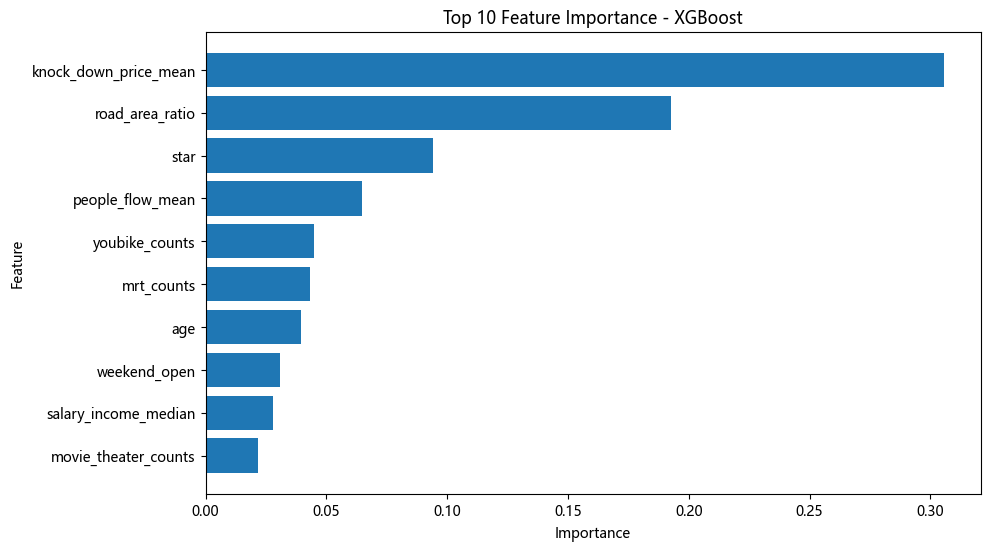

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

feature_names = X_train.columns
importances = best_xgb_model.feature_importances_
feature_importance = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# 按照重要性進行降序排列
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# 顯示排序後的DataFrame
print(feature_importance)


# 繪製特徵重要性的水平條形圖，重要性較高的特徵會顯示在最上面
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance["Feature"][:10],
    feature_importance["Importance"][:10],
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importance - XGBoost")
plt.gca().invert_yaxis()  # 確保重要性較高的特徵顯示在最上面
plt.show()

## AdaBoost

c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy (準確率): 0.4701335207308503
Classification Report (分類報告):
               precision    recall  f1-score   support

           1       0.87      0.71      0.78       293
           2       0.39      0.33      0.36       281
           3       0.36      0.44      0.40       275
           4       0.30      0.20      0.24       276
           5       0.45      0.64      0.53       298

    accuracy                           0.47      1423
   macro avg       0.47      0.46      0.46      1423
weighted avg       0.48      0.47      0.47      1423



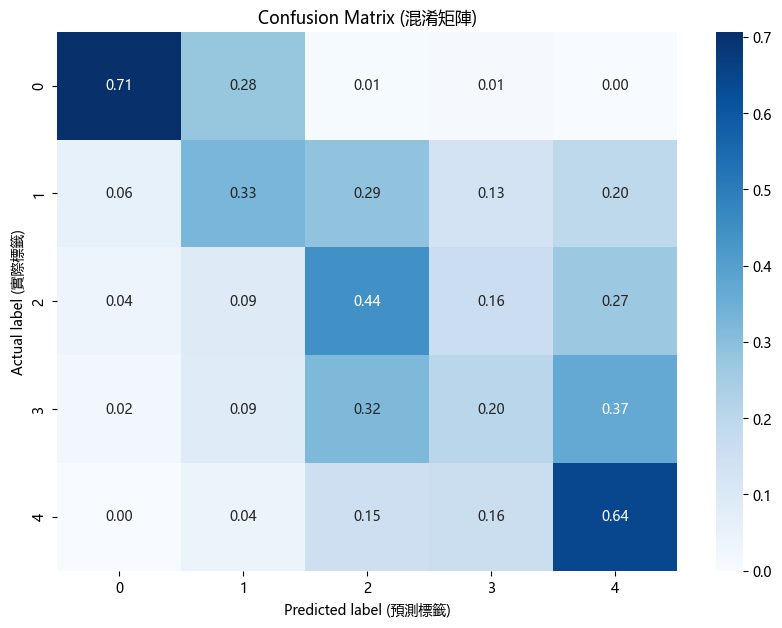

In [64]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 訓練 AdaBoost 模型
# 這裡我們設置 50 個弱學習器，並且使用決策樹作為默認的基學習器
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)

# 進行預測
y_pred_ada_transformed = ada_model.predict(X_test)

# 計算準確率和其他性能指標
accuracy_ada = accuracy_score(y_test, y_pred_ada_transformed)
classification_report_ada = classification_report(y_test, y_pred_ada_transformed)

# 將預測結果轉換回原始範圍（1~5）
y_pred_ada_original = y_pred_ada_transformed + 1

# 輸出結果
print(f"Accuracy (準確率): {accuracy_ada}")
print("Classification Report (分類報告):\n", classification_report_ada)

# 如果您需要使用預測結果進行其他操作，請使用 y_pred_ada_original

# 計算混淆矩陣
cm = confusion_matrix(y_test, y_pred_ada_transformed)

# 轉換為比例
cm_ratio = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# 使用Seaborn畫出混淆矩陣的熱力圖
plt.figure(figsize=(10, 7))
sns.heatmap(cm_ratio, annot=True, fmt=".2f", cmap="Blues")  # fmt='.2f' 指定顯示兩位小數
plt.title("Confusion Matrix (混淆矩陣)")
plt.ylabel("Actual label (實際標籤)")
plt.xlabel("Predicted label (預測標籤)")
plt.show()

### 交叉驗證(Cross-Validation)

In [65]:
from sklearn.model_selection import cross_val_score

# 定義 AdaBoost 分類器
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)

# 進行交叉驗證，cv 參數指定交叉驗證的折數
# 如果資料集較小，您可以考慮使用較大的折數，例如 cv=10
# 請確保 X 和 y 是您的特徵和標籤資料
# 這個過程可能會花費一些時間，特別是當資料集很大時
cv_scores = cross_val_score(ada_model, X, y, cv=5)

# 輸出交叉驗證結果
print("交叉驗證準確率:", cv_scores)
print("平均交叉驗證準確率:", np.mean(cv_scores))

c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the defa

交叉驗證準確率: [0.35932561 0.46153846 0.46518987 0.2742616  0.35548523]
平均交叉驗證準確率: 0.3831601552600339


c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### 參數調整(Parameter Tuning)

In [74]:
# 忽略警告用的
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# 定義參數範圍
param_grid_ada = {
    "n_estimators": [10, 50, 100, 200],
    "learning_rate": [0.01, 0.1, 1, 10],
}
param_dist_ada = {"n_estimators": randint(50, 500), "learning_rate": [0.01, 0.1, 1, 10]}

# 創建 GridSearchCV 和 RandomizedSearchCV 物件
grid_search_ada = GridSearchCV(
    AdaBoostClassifier(random_state=42), param_grid_ada, refit=True, verbose=0
)
random_search_ada = RandomizedSearchCV(
    AdaBoostClassifier(random_state=42),
    param_distributions=param_dist_ada,
    n_iter=100,
    refit=True,
    verbose=0,
)

# 執行擬合
grid_search_ada.fit(X_train, y_train)
random_search_ada.fit(X_train, y_train)

# 選擇最佳模型
best_model_grid_ada = grid_search_ada.best_estimator_
best_model_random_ada = random_search_ada.best_estimator_

# 打印最佳參數
print(
    "Best parameters (GridSearchCV) (最佳參數-網格搜索):", grid_search_ada.best_params_
)
print(
    "Best parameters (RandomizedSearchCV) (最佳參數-隨機搜索):",
    random_search_ada.best_params_,
)

# 使用最佳模型進行預測
y_pred_ada_best_grid = best_model_grid_ada.predict(X_test)
y_pred_ada_best_random = best_model_random_ada.predict(X_test)

# 您可以基於 y_pred_ada_best_grid 和 y_pred_ada_best_random 進行進一步的分析和評估

# 計算準確率
accuracy_ada_best_grid = accuracy_score(y_test, y_pred_ada_best_grid)
accuracy_ada_best_random = accuracy_score(y_test, y_pred_ada_best_random)

# 打印準確率
print("Accuracy (GridSearchCV) (準確率-網格搜索):", accuracy_ada_best_grid)
print("Accuracy (RandomizedSearchCV) (準確率-隨機搜索):", accuracy_ada_best_random)

# 比較準確率並選擇最好的模型
if accuracy_ada_best_grid > accuracy_ada_best_random:
    AdaBoost_model_best = best_model_grid_ada
    print("GridSearchCV 的模型表現較好。")
else:
    AdaBoost_model_best = best_model_random_ada
    print("RandomizedSearchCV 的模型表現較好。")

# 使用最佳模型進行其他操作
# 例如，您可以使用 best_model 進行更多預測或進行深入分析

c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the defa

Best parameters (GridSearchCV) (最佳參數-網格搜索): {'learning_rate': 1, 'n_estimators': 100}
Best parameters (RandomizedSearchCV) (最佳參數-隨機搜索): {'learning_rate': 1, 'n_estimators': 97}
Accuracy (GridSearchCV) (準確率-網格搜索): 0.4462403373155306
Accuracy (RandomizedSearchCV) (準確率-隨機搜索): 0.45537596626844695
RandomizedSearchCV 的模型表現較好。


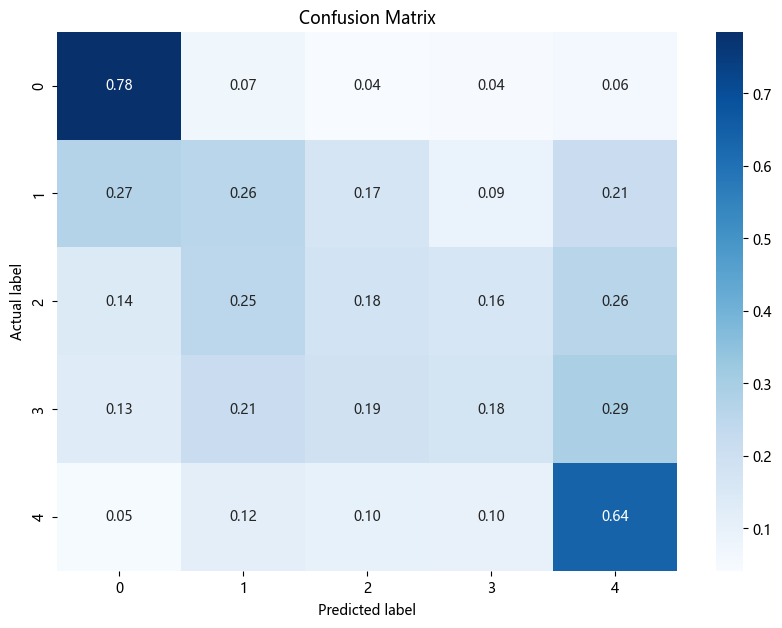

c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the defa

Cross Validation Scores: [0.41833509 0.45626976 0.46624473 0.23628692 0.407173  ]
平均準確率: 0.39686189771155955


c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the defa

['AdaBoost_model_best.joblib']

In [78]:
# 忽略警告用的
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

plot_confusion_matrix(y_test, y_pred)

from sklearn.model_selection import cross_val_score

# 使用交叉驗證評估模型
cross_val_scores = cross_val_score(AdaBoost_model_best, X, y, cv=5)  # 使用5折交叉驗證

# 打印每次交叉驗證的準確度
print("Cross Validation Scores:", cross_val_scores)
# 打印平均交叉驗證準確度
print("平均準確率:", cross_val_scores.mean())

scores = cross_val_score(AdaBoost_model_best, X_train, y_train, cv=5)

"""輸出模型"""
from joblib import dump, load

# 保存模型
dump(AdaBoost_model_best, "AdaBoost_model_best.joblib")

                          Feature  Importance
0                            star    0.247423
12           salary_income_median    0.123711
2                    drink_counts    0.103093
4                  youbike_counts    0.082474
5                      bus_counts    0.072165
14          knock_down_price_mean    0.072165
16                road_area_ratio    0.051546
8        sports_facilities_counts    0.041237
18  weekday_working_hours_average    0.041237
6                     park_counts    0.041237
10           movie_theater_counts    0.020619
11                hospital_counts    0.020619
13               people_flow_mean    0.020619
17                            age    0.020619
1                   school_counts    0.010309
7             night_market_counts    0.010309
15                   weekend_open    0.010309
9                      mrt_counts    0.010309
3                    train_counts    0.000000


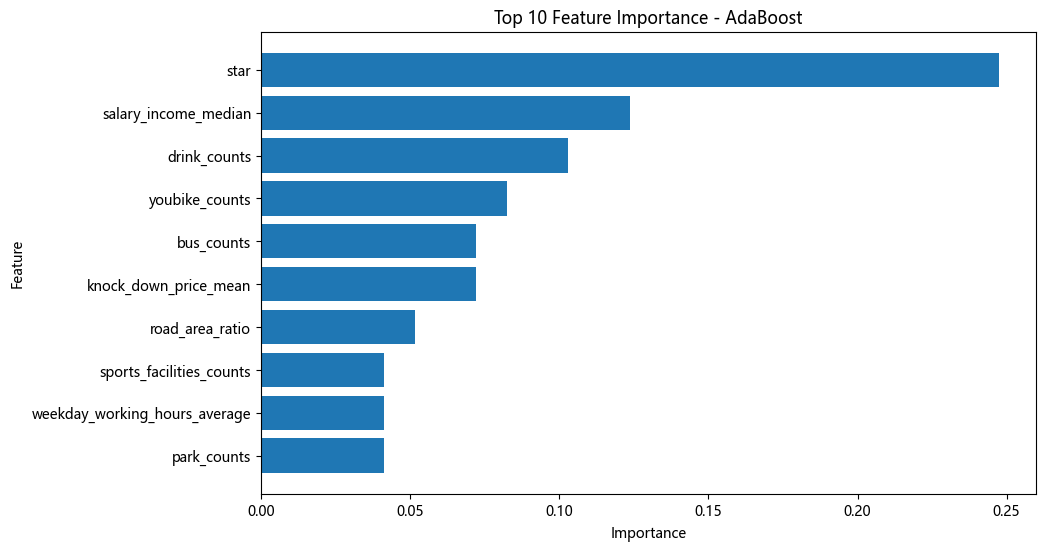

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 AdaBoost_model_best 是您的训练好的模型
feature_names = X_train.columns  # X_train 是训练数据集
importances = AdaBoost_model_best.feature_importances_  # 获取特征重要性
feature_importance = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# 按照重要性进行降序排列
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# 显示排序后的DataFrame
print(feature_importance)

# 绘制特征重要性的水平条形图，重要性较高的特征会显示在最上面
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance["Feature"][:10],  # 只显示前10个特征
    feature_importance["Importance"][:10],
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importance - AdaBoost")
plt.gca().invert_yaxis()  # 确保重要性较高的特征显示在最上面
plt.show()

# 集成式學習

## 載入模型

Boosting

Bagging

https://chat.openai.com/c/5148fbf7-f239-4393-876b-aa680d7293c5